# Imports

In [1]:
# dodajemo sve potrebne importe
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from scipy.ndimage.interpolation import shift

# Utility functions

In [2]:
# funkcija za crtanje
def plot_curve( epochs, hist, list_of_metrics):
    plt.figure()
    plt.xlabel( 'Epoch')
    plt.ylabel( 'Value')
    
    for m in list_of_metrics:
        x = hist[m]
        plt.plot( epochs[1:], x[1:], label=m)
        
    plt.legend()

In [3]:
def shift_data( data, direction):
    len = data.shape[0]
    data_copy = data.reshape( len, 28, 28)
    
    if direction == "left":
        shift_dir = ( 0, 0, -1)
    elif direction == "right":
        shift_dir = ( 0, 0, 1)
    elif direction == "up":
        shift_dir = ( 0, -1, 0)
    elif direction == "down":
        shift_dir = ( 0, 1, 0)
    else: 
        raise ValueError( "uknown direction value")
    
    return shift( data_copy, shift_dir, cval=0).reshape( len, 28, 28, 1)

In [4]:
# inicijalno je dataset rotiran za 90 stupnjeva i zrcaljen, mozemo tranirati i na tome, ali mozemo ih i vratiti u originalan oblik
def reshape_rot_flip( img):
    img = np.rot90(img, k=-1, axes=(0,1))
    img = np.flip( img, (1))
    return img

In [5]:
def plot_digit( data):
    image = data.reshape( 28, 28)
    plt.imshow( image, cmap = mpl.cm.binary, interpolation="nearest")
    plt.axis( "off")

# Load data

In [6]:
# ucitavanje podataka
train, test = tfds.load( 'emnist/balanced', split=['train', 'test'], shuffle_files=True)
df_train = tfds.as_dataframe( train)
df_test = tfds.as_dataframe( test)

In [7]:
# vracanje podataka u originalan oblik
x_train = np.stack( [reshape_rot_flip(img) for img in df_train['image']]) / 255
y_train = df_train['label'].to_numpy()
x_test = np.stack( [reshape_rot_flip(img) for img in df_test['image']]) / 255
y_test = df_test['label'].to_numpy()

 0 = 0 |
 1 = 1 |
 2 = 2 |
 3 = 3 |
 4 = 4 |
 5 = 5 |
 6 = 6 |
 7 = 7 |
 8 = 8 |
 9 = 9 |
 10 = A |
 11 = B |
 12 = C c |
 13 = D |
 14 = E |
 15 = F |
 16 = G |
 17 = H |
 18 = I i |
 19 = J j |
 20 = K k |
 21 = L l |
 22 = M m |
 23 = N |
 24 = O o |
 25 = P p |
 26 = Q |
 27 = R |
 28 = S s |
 29 = T |
 30 = U u |
 31 = V v |
 32 = W w |
 33 = X x |
 34 = Y y |
 35 = Z z |
 36 = a |
 37 = b |
 38 = d |
 39 = e |
 40 = f |
 41 = g |
 42 = h |
 43 = n |
 44 = q |
 45 = r |
 46 = t |

# Data augmentation

In [7]:
X_train_shift_left = shift_data( x_train, "left")
X_train_shift_right = shift_data( x_train, "right")
X_train_shift_up = shift_data( x_train, "up")
X_train_shift_down = shift_data( x_train, "down")

In [8]:
X_augmented = np.concatenate( (x_train, X_train_shift_left, X_train_shift_right, 
                               X_train_shift_up, X_train_shift_down))
Y_augmented = np.concatenate( (y_train, y_train, y_train, y_train, y_train))

shuffle_index = np.random.permutation( X_augmented.shape[0])
X_augmented = X_augmented[ shuffle_index]
Y_augmented = Y_augmented[ shuffle_index]

# Architecture

In [24]:
# kompleksni model
def create_model( learning_rate):
    model = tf.keras.models.Sequential()
    
    model.add( tf.keras.layers.Conv2D( filters=128, kernel_size=(3,3), activation='elu', input_shape=(28,28,1)))
    model.add( tf.keras.layers.MaxPool2D( pool_size=(2,2), strides=2))
    model.add( tf.keras.layers.Conv2D( filters=256, kernel_size=(3,3), activation='elu', padding='same'))
    model.add( tf.keras.layers.MaxPool2D( pool_size=(2,2), strides=2))
    model.add( tf.keras.layers.Dropout( rate=0.4))
    model.add( tf.keras.layers.Conv2D( filters=256, kernel_size=(3,3), activation='elu', padding='same'))
    model.add( tf.keras.layers.MaxPool2D( pool_size=(2,2), strides=2))
    
    model.add( tf.keras.layers.Flatten())
    model.add( tf.keras.layers.Dropout( rate=0.6))
    model.add( tf.keras.layers.Dense( 128, activation='elu'))
    model.add( tf.keras.layers.Dense( 47, activation='softmax'))
    
    model.compile( optimizer=tf.keras.optimizers.Adam( learning_rate=learning_rate),
                    loss="sparse_categorical_crossentropy",
                    metrics=['accuracy'])
    
    return model

In [104]:
# jednostavni model
def create_model( learning_rate):
    model = tf.keras.models.Sequential()
    
    model.add( tf.keras.layers.Conv2D( filters=32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)))
    model.add( tf.keras.layers.MaxPool2D( pool_size=(2,2), strides=2))
    model.add( tf.keras.layers.Conv2D( filters=64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add( tf.keras.layers.MaxPool2D( pool_size=(2,2), strides=2))
    model.add( tf.keras.layers.Conv2D( filters=64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add( tf.keras.layers.MaxPool2D( pool_size=(2,2), strides=2))
    
    model.add( tf.keras.layers.Flatten())
    model.add( tf.keras.layers.Dropout( rate=0.6))
    model.add( tf.keras.layers.Dense( 128, activation='elu'))
    model.add( tf.keras.layers.Dense( 47, activation='softmax'))
    
    model.compile( optimizer=tf.keras.optimizers.Adam( learning_rate=learning_rate),
                    loss="sparse_categorical_crossentropy",
                    metrics=['accuracy'])
    
    return model

# Train function

In [8]:
# funkcija koja trenira model
def train_model( model, train_features, train_label, epochs,
                    batch_size=None, validation_split=0.1):

    history = model.fit( x=train_features, y=train_label, batch_size=batch_size,
                           epochs=epochs, shuffle=True,
                           validation_split=validation_split)
    
    epochs = history.epoch
    hist = pd.DataFrame( history.history)
    
    return epochs, hist

# Main

In [12]:
# hiperparametri
initial_learning_rate = 0.001
decay_steps = 500000
decay_rate = 1/10
global_step = tf.Variable( 0, trainable=False, name="global_step")
learning_rate = tf.compat.v1.train.exponential_decay( initial_learning_rate, global_step, decay_steps, decay_rate)
epochs = 50
batch_size = 2048
validation_split = 0.2

In [28]:
# model
my_model = create_model( 0.001)

Epoch 1/50
45/45 [==============================] - 13s 298ms/step - loss: 0.2060 - accuracy: 0.9172 - val_loss: 0.3047 - val_accuracy: 0.8967
Epoch 2/50
45/45 [==============================] - 13s 296ms/step - loss: 0.1994 - accuracy: 0.9182 - val_loss: 0.3036 - val_accuracy: 0.8973
Epoch 3/50
45/45 [==============================] - 13s 297ms/step - loss: 0.1954 - accuracy: 0.9207 - val_loss: 0.3026 - val_accuracy: 0.8975
Epoch 4/50
45/45 [==============================] - 13s 297ms/step - loss: 0.1954 - accuracy: 0.9213 - val_loss: 0.3043 - val_accuracy: 0.8974
Epoch 5/50
45/45 [==============================] - 13s 297ms/step - loss: 0.1945 - accuracy: 0.9209 - val_loss: 0.3031 - val_accuracy: 0.8967
Epoch 6/50
45/45 [==============================] - 13s 297ms/step - loss: 0.1939 - accuracy: 0.9212 - val_loss: 0.3043 - val_accuracy: 0.8969
Epoch 7/50
45/45 [==============================] - 13s 298ms/step - loss: 0.1907 - accuracy: 0.9228 - val_loss: 0.3037 - val_accuracy: 0.8973

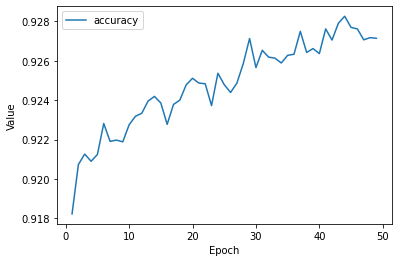

In [36]:
# train
epochs, hist = train_model( my_model, x_train, y_train,
                                  epochs, batch_size, validation_split)

# nacrtaj graf preciznosti po epohama
list_of_metrics_to_plot = ['accuracy']
plot_curve( epochs, hist, list_of_metrics_to_plot)

In [9]:
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 128)       1280      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 128)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 6, 6, 256)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 6, 256)        

In [13]:
print("\n Evaluate the new model against the test set:")
my_model.evaluate( x=x_test, y=y_test, batch_size=batch_size)


 Evaluate the new model against the test set:
10/10 [==============================] - 6s 112ms/step - loss: 0.3348 - accuracy: 0.8934


[0.33477482199668884, 0.8933510780334473]

In [34]:
from keras import backend as K
K.set_value(my_model.optimizer.learning_rate, 0.0001)

# Save model

In [38]:
#my_model.save( 'final_complex_v1.0')

INFO:tensorflow:Assets written to: final_complex_v1.0\assets


INFO:tensorflow:Assets written to: final_complex_v1.0\assets


# Load model

In [8]:
my_model = tf.keras.models.load_model('final_complex_v1.0')

# Analysis

0.8948936170212766


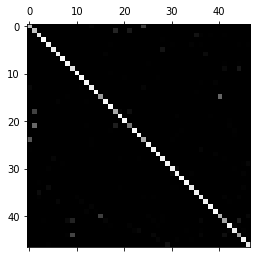

In [137]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_predict = my_model.predict( x_test).argmax(axis=-1)
print( accuracy_score( y_test, y_predict))
conf_mx = confusion_matrix( y_test, y_predict)
plt.matshow( conf_mx, cmap=plt.cm.gray)
plt.show()

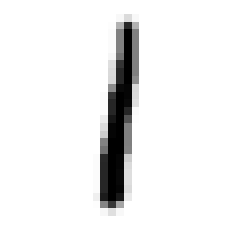

In [205]:
temp = x_test[ y_test == 21]
plot_digit( temp[0])

In [199]:
prediction = my_model.predict( temp.reshape(-1, 28, 28, 1))
np.argmax( prediction, axis=1)

array([ 1, 42, 21,  1, 18, 21, 21, 18,  1,  1, 21, 18,  1,  1,  1,  1,  1,
       21, 21, 21, 21,  1,  1, 21,  1,  1,  1, 18, 21, 21,  1, 18,  1,  1,
       21,  1, 18,  1, 12, 21, 21,  1,  1,  1,  1,  1,  1, 21,  1, 21, 21,
       18, 21,  1, 21, 21,  1,  1, 21, 21,  1, 21, 18, 21, 21, 21, 18, 18,
        1, 21, 21,  1,  1,  1, 21, 21, 21,  1,  1,  1, 21, 18, 21,  1, 18,
       21, 41, 21, 21,  1,  1, 21,  1,  1, 21, 21, 21,  1, 21, 21,  1, 21,
       21, 21, 21,  1, 21, 21, 21, 18,  1, 40,  1, 18, 21, 21, 21,  1, 21,
       21, 21, 21, 21,  1,  1,  1, 21,  1, 18, 21, 21,  1, 21, 18, 18,  1,
        1,  1,  1, 18,  1, 21, 21, 21,  1, 21,  1, 18, 21,  1,  1,  1, 18,
       21,  1, 21,  1,  1,  1,  1, 21,  1, 21, 21,  1, 21, 18, 21, 21, 21,
       21,  1,  1, 21, 21, 21,  1,  1, 21,  1,  1, 21, 21,  1,  1, 21, 18,
       21, 21,  1,  1, 21,  1,  1, 21, 21, 21,  1, 21, 21, 21, 21,  1, 21,
       21, 21,  1,  1, 21,  1, 21,  1, 18, 21,  1, 21, 21, 18,  1, 19, 21,
       21, 21, 21,  1, 18